### Preparing the Dataset

In [23]:
import pandas as pd

In [24]:
# Load the morphology data 
gz_df = pd.read_csv('./gz_candels_table_2_main_release.csv')

# Preview the data
print(gz_df.head())
print(gz_df.columns)

          ID         RA       Dec  ...  clean_edge_on  clean_spiral  smooth_disk
0      COS_1  150.05682  2.173421  ...          False         False        False
1     COS_10  150.05686  2.174979  ...          False         False        False
2   COS_1000  150.08497  2.191447  ...          False         False        False
3  COS_10000  150.08217  2.299318  ...          False         False        False
4  COS_10002  150.20334  2.299440  ...          False         False        False

[5 rows x 146 columns]
Index(['ID', 'RA', 'Dec', 'num_classifications',
       'num_classifications_weighted', 't00_smooth_or_featured_a0_smooth_frac',
       't00_smooth_or_featured_a1_features_frac',
       't00_smooth_or_featured_a2_artifact_frac',
       't00_smooth_or_featured_a0_smooth_weighted_frac',
       't00_smooth_or_featured_a1_features_weighted_frac',
       ...
       't16_merging_tidal_debris_a3_neither_weighted_frac',
       't16_merging_tidal_debris_count', 't16_merging_tidal_debris_weight'

In [25]:
# Define column names for physical properties catalog
columns = [
    'id_candels', 'candels_field', 'ra', 'dec',
    'log_Mstar', 'log_Mstar_err',
    'log_SFR', 'log_SFR_err',
    'A_FUV', 'A_FUV_err',
    'A_V', 'A_V_err',
    'log_Ldust', 'log_Ldust_err',
    'z'
]

# Load the physical properties catalog
phys_df = pd.read_csv('./OsborneSalim2023_CANDELS_catalog.txt', delim_whitespace=True, comment='#', header=None, names=columns)

# Filter for GOODS-S field only
phys_df = phys_df[phys_df['candels_field'] == 'GOODS-S'].reset_index(drop=True)
print(phys_df.shape)

# Preview the data
print(phys_df.head())
print(phys_df.columns)

(13752, 15)
   id_candels candels_field        ra  ...  log_Ldust  log_Ldust_err      z
0          22       GOODS-S  53.09084  ...     10.529          0.156  0.905
1          24       GOODS-S  53.08643  ...     10.339          0.460  2.254
2          36       GOODS-S  53.10218  ...      9.963          0.189  0.761
3          38       GOODS-S  53.10448  ...     10.731          0.169  1.548
4          40       GOODS-S  53.08826  ...     11.464          0.156  1.086

[5 rows x 15 columns]
Index(['id_candels', 'candels_field', 'ra', 'dec', 'log_Mstar',
       'log_Mstar_err', 'log_SFR', 'log_SFR_err', 'A_FUV', 'A_FUV_err', 'A_V',
       'A_V_err', 'log_Ldust', 'log_Ldust_err', 'z'],
      dtype='object')


In [26]:
from astropy.coordinates import SkyCoord
from astropy import units as u 

# Create SkyCoord objects 
gz_coords = SkyCoord(ra=gz_df['RA'].values * u.deg, dec=gz_df['Dec'].values * u.deg)
phys_coords = SkyCoord(ra=phys_df['ra'].values * u.deg, dec=phys_df['dec'].values * u.deg)

# Perform nearest-neighbor matching 
idx, d2d, _ = gz_coords.match_to_catalog_sky(phys_coords)

# Filter matches within a small radius
tolerance = 0.5 * u.arcsec
mask = d2d < tolerance

# Build matched dataframes
gz_matched = gz_df[mask].reset_index(drop=True)
phys_matched = phys_df.iloc[idx[mask]].reset_index(drop=True)

# Combine both 
merged_df = pd.concat([gz_matched, phys_matched], axis=1)

# Preview the merged dataframe
print("Matched galaxies:", merged_df.shape[0])
print(merged_df[['ID', 'log_Mstar', 'log_SFR', 'z']].head())

# Save merged catalog 
merged_df.to_csv('galaxy_zoo_candels_merged.csv', index=False)

Matched galaxies: 7403
          ID  log_Mstar  log_SFR      z
0  GDS_10000      8.917   -0.116  1.070
1  GDS_10003      8.756   -0.002  1.349
2  GDS_10009      9.596    0.459  1.616
3   GDS_1001      9.284   -0.131  1.596
4  GDS_10010      9.564    0.413  1.538


### Analysis

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [28]:
# Drop rows with missing data in key columns
merged_df = merged_df.dropna(subset=[
    'log_Mstar', 'log_SFR', 'z',
    't00_smooth_or_featured_a0_smooth_frac',
    't00_smooth_or_featured_a1_features_frac',
    't01_how_rounded_a0_completely_frac',
    't11_bar_feature_a0_yes_frac',
    't12_spiral_pattern_a0_yes_frac',
    't15_bulge_prominence_a0_no_bulge_frac',
    't15_bulge_prominence_a2_dominant_frac',
    't02_clumpy_appearance_a0_yes_frac',
])

In [29]:
# Define morphology predictors
morph_vars = [
    't00_smooth_or_featured_a0_smooth_frac',
    't00_smooth_or_featured_a1_features_frac',
    't01_how_rounded_a0_completely_frac',
    't11_bar_feature_a0_yes_frac',
    't12_spiral_pattern_a0_yes_frac',
    't15_bulge_prominence_a0_no_bulge_frac',
    't15_bulge_prominence_a2_dominant_frac',
    't02_clumpy_appearance_a0_yes_frac',
]

# Define physical response variables 
phys_vars = ['log_Mstar', 'log_SFR', 'z']

# Select relevant columns for analysis 
df_analysis = merged_df[morph_vars + phys_vars]

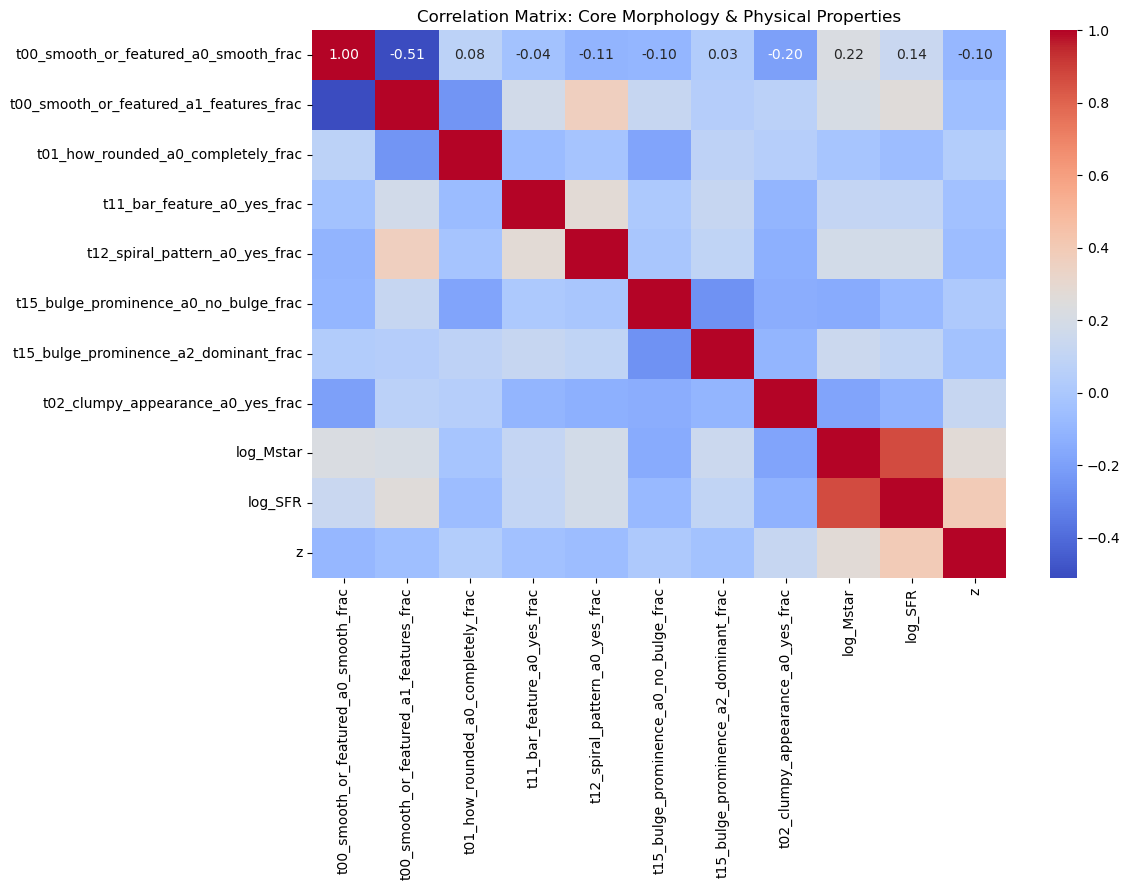

In [30]:
# Correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(df_analysis.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Core Morphology & Physical Properties")
plt.tight_layout()
plt.show()

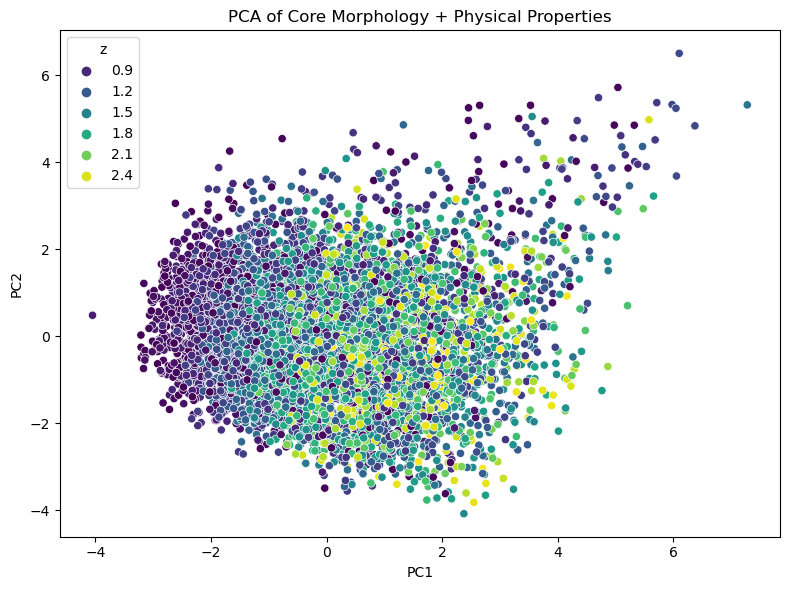


Top Loadings for PC1:
log_SFR                                    0.581447
log_Mstar                                  0.572104
t12_spiral_pattern_a0_yes_frac             0.293324
t00_smooth_or_featured_a1_features_frac    0.292358
z                                          0.230775
t11_bar_feature_a0_yes_frac                0.213416
t15_bulge_prominence_a2_dominant_frac      0.171053
t00_smooth_or_featured_a0_smooth_frac      0.023901
t15_bulge_prominence_a0_no_bulge_frac     -0.080357
t01_how_rounded_a0_completely_frac        -0.080623
t02_clumpy_appearance_a0_yes_frac         -0.146672
dtype: float64


In [38]:
# Standardize all variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_analysis)

# PCA on combined data
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['z'] = df_analysis['z']

# Plot PCA scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=pca_df['z'], palette='viridis')
plt.title("PCA of Core Morphology + Physical Properties")
plt.tight_layout()
plt.show()

# PCA Loadings
print("\nTop Loadings for PC1:")
pc1_loadings = pd.Series(pca.components_[0], index=df_analysis.columns)
print(pc1_loadings.sort_values(ascending=False))


Regression Coefficients (Standardized Predictors):
                                         log_Mstar  log_SFR      z
t00_smooth_or_featured_a0_smooth_frac        0.265    0.209 -0.067
t00_smooth_or_featured_a1_features_frac      0.288    0.268 -0.058
t01_how_rounded_a0_completely_frac           0.022    0.000  0.009
t11_bar_feature_a0_yes_frac                  0.017    0.011 -0.005
t12_spiral_pattern_a0_yes_frac               0.022    0.030 -0.009
t15_bulge_prominence_a0_no_bulge_frac       -0.112   -0.066  0.013
t15_bulge_prominence_a2_dominant_frac        0.031    0.018 -0.004
t02_clumpy_appearance_a0_yes_frac           -0.098   -0.053  0.051


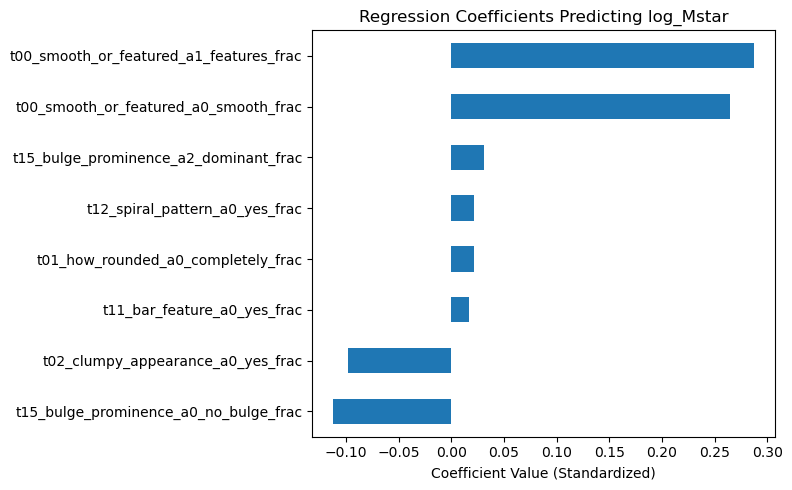

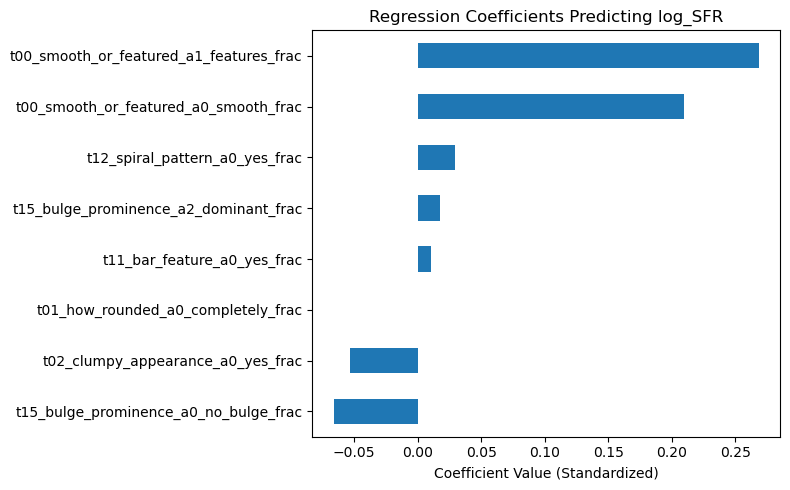

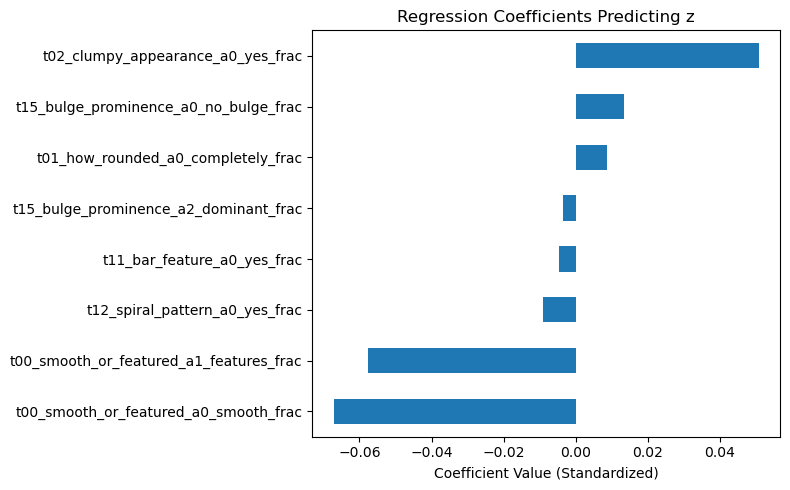

R² Scores for Multivariate Regression:
log_Mstar: 0.249
log_SFR: 0.187
z: 0.035


In [35]:
# Multivariate linear regression: morphology predictors → physical responses
X = merged_df[morph_vars]
Y = merged_df[phys_vars]

# Standardize predictors
X_scaled = StandardScaler().fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, Y)

Y_pred = model.predict(X_scaled)

# Create dataframe for coefficients
coef_df = pd.DataFrame(model.coef_.T, index=morph_vars, columns=phys_vars)

print("\nRegression Coefficients (Standardized Predictors):")
print(coef_df.round(3))

# Plot coefficients as a bar chart
for col in coef_df.columns:
    coef_df[col].sort_values().plot(kind='barh', figsize=(8, 5))
    plt.title(f"Regression Coefficients Predicting {col}")
    plt.xlabel("Coefficient Value (Standardized)")
    plt.tight_layout()
    plt.show()

# R² scores for each physical property
r2_scores = {phys_vars[i]: r2_score(Y.iloc[:, i], Y_pred[:, i]) for i in range(len(phys_vars))}

print("R² Scores for Multivariate Regression:")
for var, r2 in r2_scores.items():
    print(f"{var}: {r2:.3f}")

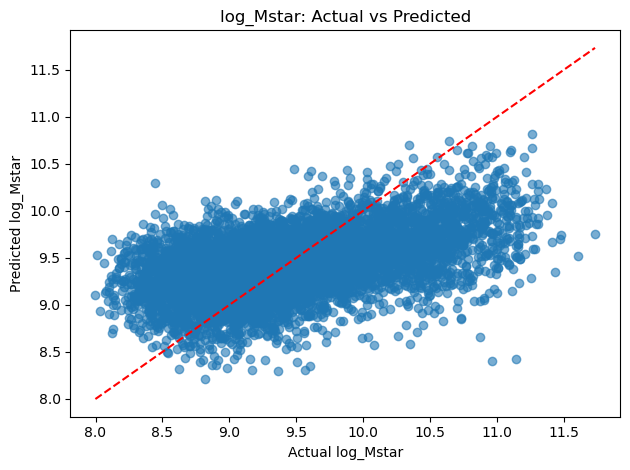

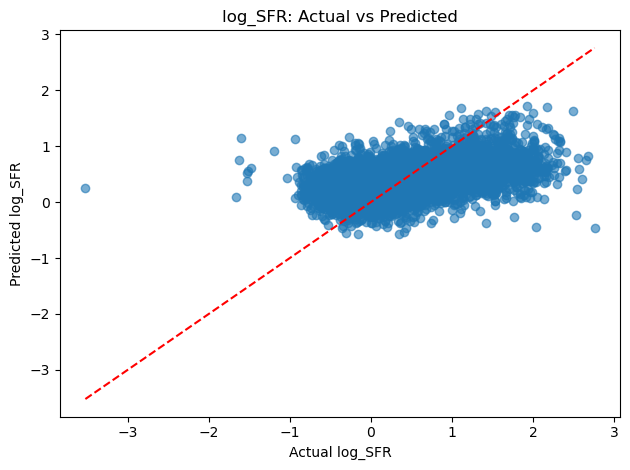

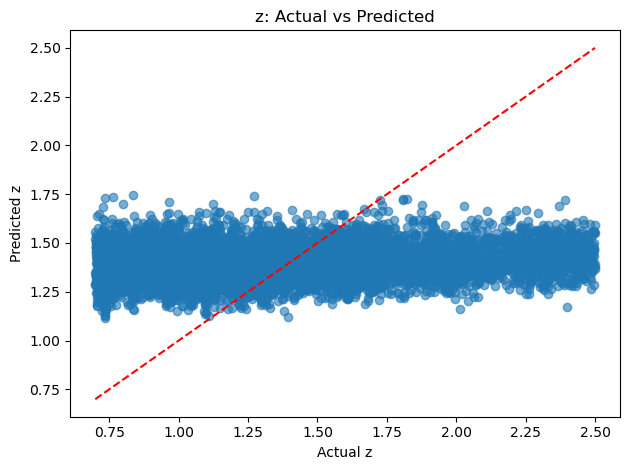

In [33]:
# Actual vs. predicted plots 
for i, var in enumerate(phys_vars):
    plt.figure()
    plt.scatter(Y.iloc[:, i], Y_pred[:, i], alpha=0.6)
    plt.plot([Y.iloc[:, i].min(), Y.iloc[:, i].max()],
             [Y.iloc[:, i].min(), Y.iloc[:, i].max()],
             '--', color='red')
    plt.xlabel(f"Actual {var}")
    plt.ylabel(f"Predicted {var}")
    plt.title(f"{var}: Actual vs Predicted")
    plt.tight_layout()
    plt.show()